# Preparing Data and Model Building

In [1]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer

#create a wordcloud of often used words
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#building baseline classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Grid search cross validation
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#train_data = pd.read_csv("gs://bilderkennung_nf_2020/data /jigsaw-toxic-comment-train.csv")

In [3]:
train_data = pd.read_csv('./jigsaw-toxic-comment-train.csv')

In [4]:
#valid_data = pd.read_csv("gs://bilderkennung_nf_2020/data /validation.csv")

In [5]:
valid_data = pd.read_csv("./validation.csv")

In [6]:
train_data = train_data.drop('id', axis=1)

In [7]:
train_data.head(2)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [8]:
valid_data = valid_data.drop('id', axis=1)

In [9]:
valid_data.head(2)

,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0


## Second Baseline Model LSTM

In the following steps, we will set the key model parameters and split the data.
- “MAX_NB_WORDS” sets the maximum number of words to consider as features for tokenizer.
- “MAX_SEQUENCE_LENGTH” cuts off texts after this number of words (among the MAX_NB_WORDS most common words).
- “VALIDATION_SPLIT” sets a portion of data for validation and not used in training.
- “EMBEDDING_DIM” defines the size of the “vector space”.
- “GLOVE_DIR” defines the GloVe file directory.
- Split the data into the texts and the labels.


In [10]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [11]:
import os
import glob

In [12]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
#GLOVE_DIR = 


In [13]:
train = train_data

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
comments_train = train['comment_text']
comments_train = list(comments_train)

## Preprocessing

remove stopwords, punctuation and make everything lowercase:

In [14]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")
    
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

/Users/student/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


 Have a look a sample data:

In [15]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]


Save preprocessed data to new csv file: 

In [16]:
#dt.to_csv('file_name.csv’) # relative position
#dt.to_csv('C:/Users/abc/Desktop/file_name.csv')


### Tokenizer

- We create a tokenizer, configured to only take into account the MAX_NB_WORDS most common words.
- We build the word index.
- We can recover the word index that was computed

In [17]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 431032


Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
Pad after each sequence.

In [18]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (223549, 200)
Shape of label tensor: (223549, 6)


Shuffle the data:

In [19]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

Create the train-validation split:

In [20]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [16980  1564  9607   563  8953  1690]
validation:  [4404  398 2533  126 2351  427]


## Create the model

We will use pre-trained GloVe vectors from Stanford to create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.
Then load word embeddings into an embeddings_index

In [ ]:
from laserembeddings import Laser

laser = Laser()

# if all sentences are in the same language:

embeddings = laser.embed_sentences(
    ['let your neural network be polyglot',
     'use multilingual embeddings!'],
    lang='en')  # lang is only used for tokenization

# embeddings is a N*1024 (N = number of sentences) NumPy array

In [ ]:
# If the sentences are not in the same language, you can pass a list of language codes:

embeddings = laser.embed_sentences(
    ['I love pasta.',
     "J'adore les pâtes.",
     'Ich liebe Pasta.'],
    lang=['en', 'fr', 'de'])


In [ ]:
#Then run BPE using BPEfastApply:
bpe_codes = str(MODEL_PATH / "93langs.fcodes")
BPEfastApply(
    str(CACHE_PATH / "tatoeba.cmn-eng.eng"),
    str(CACHE_PATH / "tatoeba.cmn-eng.eng.bpe"),
    bpe_codes,
    verbose=True, over_write=False)

In [ ]:
# whatever this saves
np.save("jigsaw-ml_laser.npy", embedding_matrix)

In [21]:
# might delete these embeddings since they are not multilingual

embeddings_index = {}
#with open("GloVe/glove.6B/glove.6B.50d.txt", 'r') as f:
f= open("glove.6B.100d.txt","w+")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Done.
 Proceeding with Embedding Matrix... Completed!


- Create the embedding layers.
- Specifies the maximum input length to the Embedding layer.
- Make use of the output from the previous embedding layer which outputs a 3-D tensor into the LSTM layer.
- Use a Global Max Pooling layer to to reshape the 3D tensor into a 2D one.
- We set the dropout layer to drop out 10% of the nodes.
- We define the Dense layer to produce a output dimension of 50.
- We feed the output into a Dropout layer again.
- Finally, we feed the output into a “Sigmoid” layer.

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

Its time to Compile the model into a static graph for training.
- Define the inputs, outputs and configure the learning process.
- Set the model to optimize our loss function using “Adam” optimizer, define the loss function to be “binary_crossentropy”

In [23]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

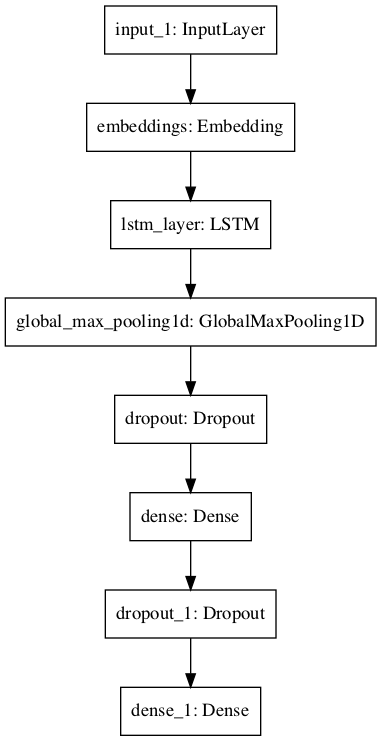

In [24]:
#visualize the model's architecture
tf.keras.utils.plot_model(model)

## Training

- Feed in a list of 32 padded, indexed sentence for each batch. The validation set will be used to assess whether the model has overfitted.
- The model will run for 2 epochs, because even 2 epochs is enough to overfit.

In [27]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Train on 178840 samples, validate on 44709 samples
Epoch 1/2
178840/178840 [==============================] - 4203s 24ms/sample - loss: 0.0827 - accuracy: 0.9739 - val_loss: 0.0809 - val_accuracy: 0.9740
Epoch 2/2
178840/178840 [==============================] - 2403s 13ms/sample - loss: 0.0787 - accuracy: 0.9747 - val_loss: 0.0767 - val_accuracy: 0.9753


## Evaluate the Model

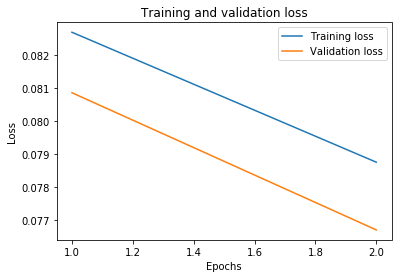

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

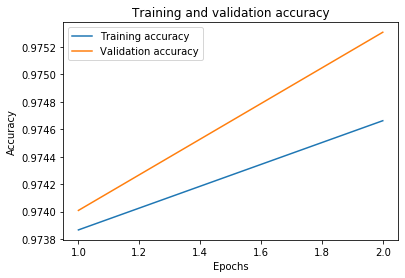

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();